In [1]:
!pip install -q transformers datasets evaluate accelerate torchvision scikit-learn matplotlib

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import (
    Compose, Normalize, RandomResizedCrop, Resize, ToTensor, CenterCrop, RandomHorizontalFlip
)
from datasets import load_dataset
import evaluate
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer
)

In [3]:
# --- CONFIGURATION ---
# Replace this with the path to your dataset root folder.
# Structure must be:
# root/
#   class_a/
#   class_b/

from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = "/content/drive/MyDrive/SENAC/2025 UC13 - Deep Learning 1/Intel Image Classification/seg_train"
MODEL_CHECKPOINT = "google/vit-base-patch16-224" # Standard Vision Transformer
BATCH_SIZE = 16

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 1. LOAD DATASET
# The "imagefolder" builder automatically detects class names from folder structure.
# We also split the train set to create a validation set if one doesn't exist.
print(f"Loading dataset from {DATASET_ROOT}...")
dataset = load_dataset("imagefolder", data_dir=DATASET_ROOT, split="train")

# Split into Train (80%) and Test/Val (20%)
# Seed ensures reproducibility for students
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits['train']
test_ds = splits['test']

# Create Label Mappings (Human-readable <-> Machine ID)
labels = train_ds.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(f"Classes found: {labels}")

Loading dataset from /content/drive/MyDrive/SENAC/2025 UC13 - Deep Learning 1/Intel Image Classification/seg_train...


Resolving data files:   0%|          | 0/14034 [00:00<?, ?it/s]

Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [33]:
# 2. PREPROCESSING & RESILIENCE
# We load the image processor associated with the pretrained model.
image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# We define transforms. This is where we handle the "outlier dimensions".
# Regardless of input size (150x150 or random), 'Resize' and 'CenterCrop'
# force the image into the 224x224 shape the ViT model expects.
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# Transforms for Training (includes augmentation)
train_transforms = Compose([
    RandomResizedCrop(image_processor.size["height"]), # handles size + augments
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

# Transforms for Validation/Test (Deterministic resizing only)
val_transforms = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    normalize,
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    # Return only the necessary columns for the model
    return {"pixel_values": example_batch["pixel_values"], "labels": example_batch["label"]}

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    # Return only the necessary columns for the model
    return {"pixel_values": example_batch["pixel_values"], "labels": example_batch["label"]}

# Apply transforms on the fly
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_val)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [34]:
# 3. METRICS
# Load a standard accuracy metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [35]:
# 4. LOAD MODEL
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, # Essential when fine-tuning on new classes
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# 5. TRAINING ARGUMENTS
# Demonstrating: Checkpointing, Evaluation Strategy, and Learning Rate
training_args = TrainingArguments(
    output_dir="./vit-custom-classifier",
    remove_unused_columns=False, # Required for image datasets in this format
    eval_strategy="epoch", # Evaluate at the end of every epoch
    save_strategy="epoch",       # Save a checkpoint at the end of every epoch
    learning_rate=5e-5,          # A standard fine-tuning learning rate
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1,          # Keep it short for demonstration
    warmup_ratio=0.1,            # Gradually increase LR to avoid shock
    logging_steps=10,            # Frequent logging for better graphs
    load_best_model_at_end=True, # Return the best model, not the last one
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to='none',
)

In [51]:
# 6. INITIALIZE TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class=image_processor, # Use image_processor as tokenizer for Trainer
    compute_metrics=compute_metrics,
)

In [52]:
# 7. TRAIN
print("Starting training...")
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.223800,0.143008,0.953687


***** train metrics *****
  epoch                    =         1.0
  total_flos               = 810282079GF
  train_loss               =      0.2945
  train_runtime            =  1:33:34.42
  train_samples_per_second =         2.0
  train_steps_per_second   =       0.125


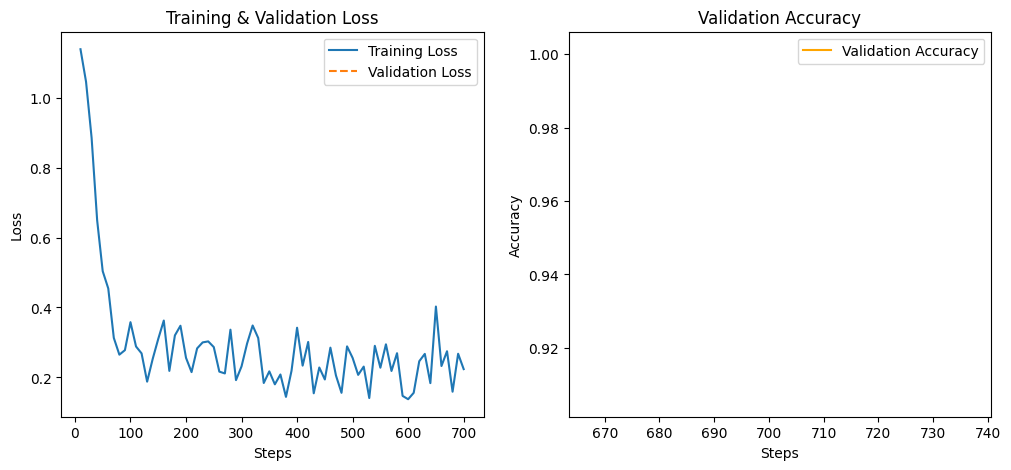

In [53]:
# 8. VISUALIZATION OF HISTORY
# Extract logs to plot learning curves
history = trainer.state.log_history

# Filter out steps that have loss or accuracy
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
steps = [x['step'] for x in history if 'loss' in x]
eval_steps = [x['step'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label='Training Loss')
# Interpolate eval steps to match train steps logic if needed, or just plot dots
plt.plot(eval_steps, eval_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

In [54]:
# 9. FINAL EVALUATION
print("\nFinal Evaluation on Test Set:")
metrics = trainer.evaluate(test_ds)
print(metrics)


Final Evaluation on Test Set:


{'eval_loss': 0.14300848543643951, 'eval_accuracy': 0.9536872105450659, 'eval_runtime': 40.9101, 'eval_samples_per_second': 68.614, 'eval_steps_per_second': 4.302, 'epoch': 1.0}
